In [19]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import *
import matplotlib.pyplot as plt
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
import time
from tqdm.auto import tqdm

In [2]:
images = "/kaggle/input/animefacedataset/images"

In [3]:
batch_size = 128

dataset = keras.utils.image_dataset_from_directory(
    directory=images,
    label_mode=None,
    batch_size=batch_size,
    image_size=(64,64),
    validation_split=0.95,
    shuffle=False,
    subset="training"
)

Found 63565 files belonging to 1 classes.
Using 3179 files for training.


In [4]:
def plot_images(X):
    plt.rcParams['figure.figsize'] = (20,20) 

    for i,x in enumerate(X[0:5]):
        x = x.numpy()
        max_= x.max()
        min_= x.min()
        xnew = np.uint(255*(x - min_)/(max_ - min_))
        plt.subplot(1,5,i + 1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

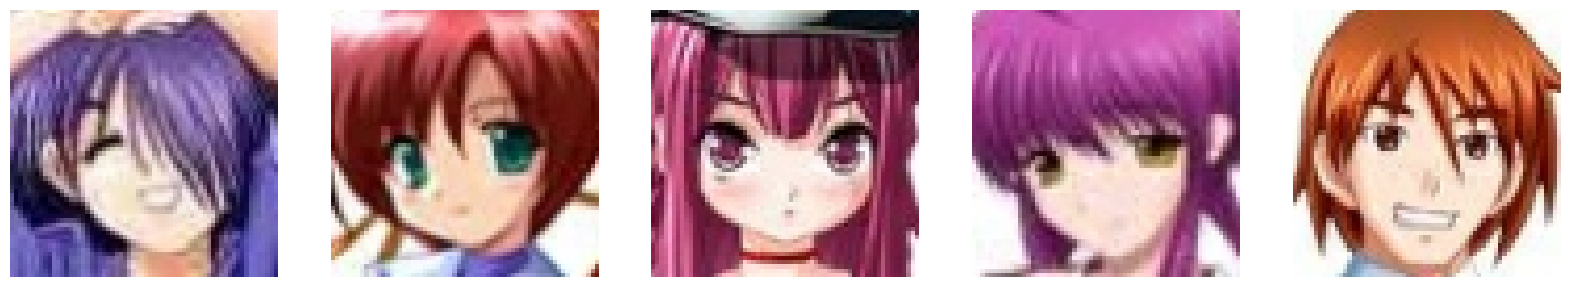

In [5]:
sample = [x for x in dataset.take(1)]
plot_images(sample[0])

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = dataset.map(lambda x: normalization_layer(x))

In [49]:
def Discriminator():
    model = Sequential()

    model.add(Input(shape = (64,64,3),name = 'input_layer'))
    model.add(Conv2D(64,kernel_size = 4,strides = 2,padding = 'same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(64*2,kernel_size =4,strides = 2,padding = 'same'))
    model.add(BatchNormalization(momentum = 0.1,epsilon = 0.8,center= 1.0,scale = 0.02)),
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(64*64,4,2,padding = 'same')),
    model.add(BatchNormalization(momentum = 0.1,epsilon = 0.8,center= 1.0,scale = 0.02))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(64*8,4,2,padding = 'same'))
    model.add(BatchNormalization(momentum = 0.1,epsilon = 0.8,center= 1.0,scale = 0.02))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, 2,padding='same', activation='sigmoid'))

    return model 

discriminator = Discriminator()

In [50]:
def Generator():
    model = Sequential()

    model.add(Input(shape=(1,1,100)))
    
    model.add(Conv2DTranspose(64*8,kernel_size = 4,strides=4, padding = 'same')),
    model.add(BatchNormalization(momentum = 0.1,epsilon = 0.8,center = 1.0,scale = 0.02)),
    model.add(ReLU())

    model.add(Conv2DTranspose(64*2,kernel_size = 4,strides = 2,padding = 'same')),
    model.add(BatchNormalization(momentum = 0.1,epsilon = 0.8,center = 1.0,scale = 0.02)),
    model.add(ReLU())

    model.add(Conv2DTranspose(64*1,kernel_size = 4,strides = 2,padding = 'same')),
    model.add(BatchNormalization(momentum = 0.1,epsilon = 0.8, center = 1.0,scale = 0.02))

    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02))
    model.add(ReLU())

    model.add(Conv2DTranspose(3, 4, 2,padding='same', activation='tanh'))

    return model


generator = Generator()

In [53]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

In [54]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

In [58]:
@tf.function 
def train_step(X, z):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        xhat = generator(z, training=True)

        real_output = discriminator(X, training=True)
        fake_output = discriminator(xhat, training=True)
        
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [59]:
latent_dim = 100

noise = tf.random.normal([batch_size, 1, 1, latent_dim])

In [ ]:
epochs = 150

for epoch in range(epochs):
    
    start = time.time()

    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):
        
        train_step(X, noise)

    noise = tf.random.normal([batch_size, 1, 1, latent_dim])
    Xhat = generator(noise,training=False)
    X = [x for x in normalized_ds]
    print("Orignal Images")
    plot_images(X[0])
    print("Generated Images")
    plot_images(Xhat)
    print (f'Time for epoch {epoch + 1} is {time.time()-start} sec')

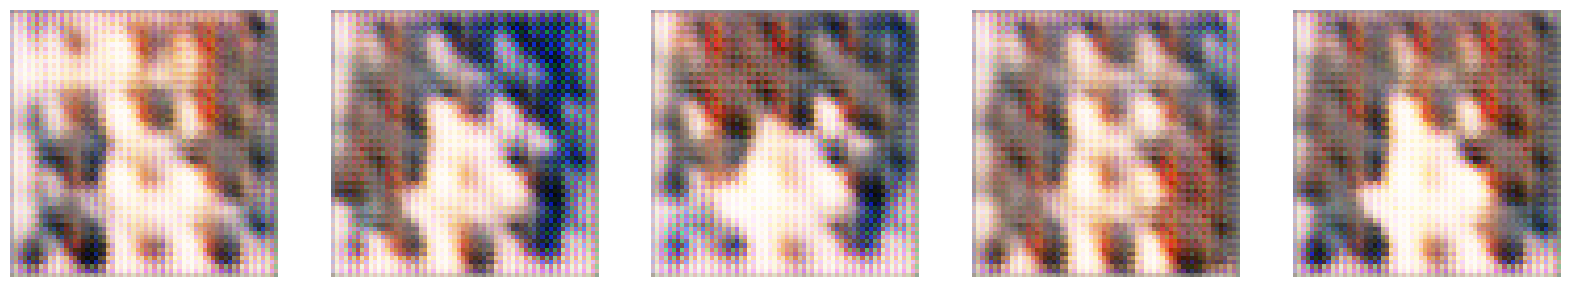

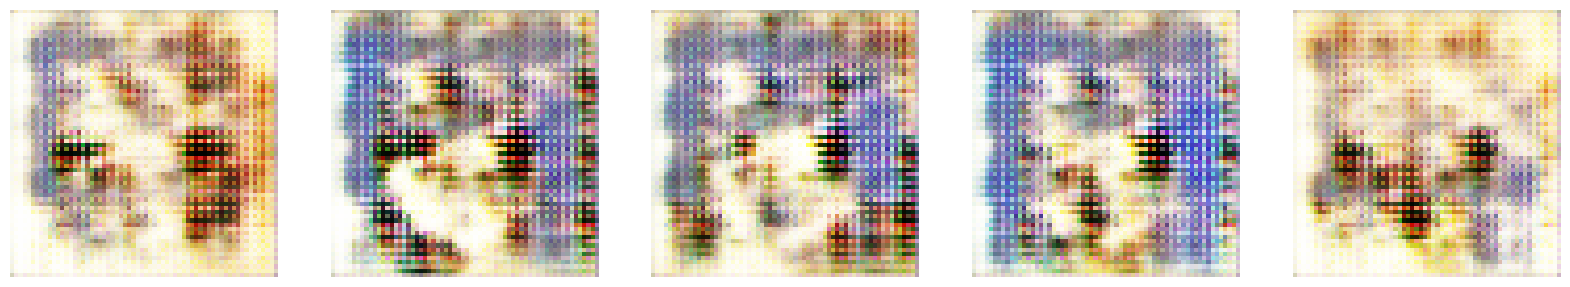

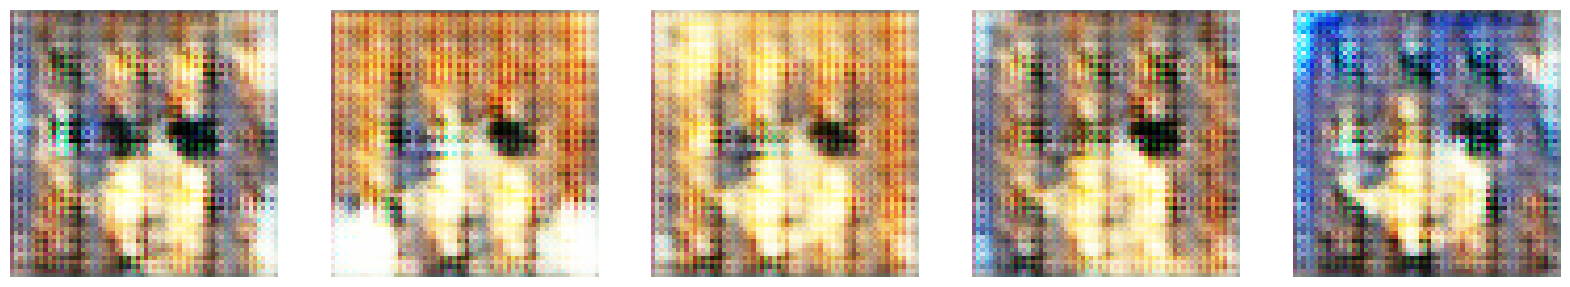

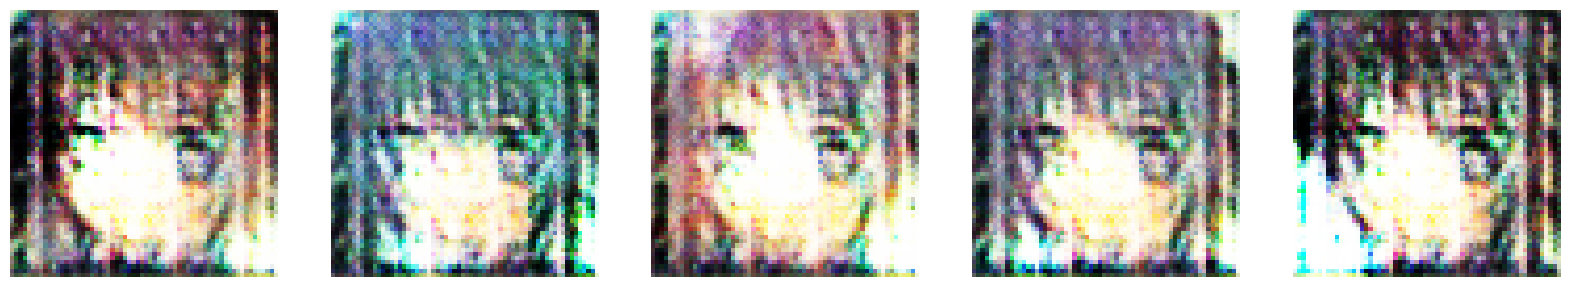

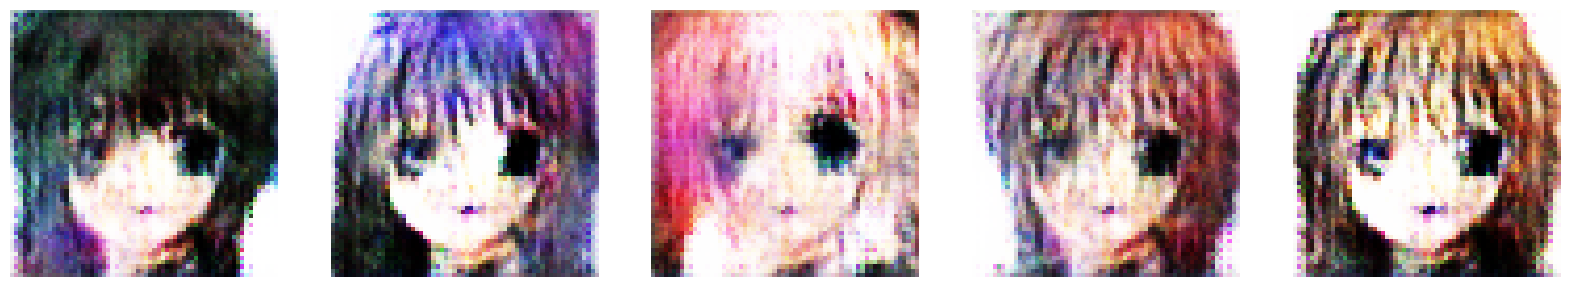